# Measurement Incompatibility Testing

In [1]:
# Make sure to load your IBM Q token before running the below block

In [2]:
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.ibmq.managed import IBMQJobManager

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

import matplotlib.pyplot as plt
import numpy as np

# custom code
import context
from device_independent_test import incompatible_measurement
from device_independent_test import quantum_communicator

In [3]:
def bb84_states():
    # Alice's half of the circuit
    # creates 0,1,+,-
    qc = QuantumCircuit(4)
    qc.x(1) # create 1
    qc.h(2) # create +
    qc.x(3) # create -
    qc.h(3) # ^
    return qc

In [4]:
def measure_circuit(y):
    # Bob's measurement circuit
    # measure in either pi/4 or 3pi/4 basis
    assert y == 0 or y == 1, "Bob's input should be 0 or 1"
    qc = QuantumCircuit(4)
    theta = -1.0*(np.pi/4 + 0.5*y*np.pi)
    qc.u3(theta,0,0,range(0,4))
    #qc.u3(theta,0,0,1)
    #qc.u3(theta,0,0,2)
    #qc.u3(theta,0,0,3)
    qc.measure_all()
    return qc

In [5]:
qc = bb84_states() + measure_circuit(0)
qc.draw()

┌───────────────┐                                   ░ ┌─┐         
   q_0: ┤ U3(-pi/4,0,0) ├───────────────────────────────────░─┤M├─────────
        └─────┬───┬─────┘┌───────────────┐                  ░ └╥┘┌─┐      
   q_1: ──────┤ X ├──────┤ U3(-pi/4,0,0) ├──────────────────░──╫─┤M├──────
              ├───┤      ├───────────────┤                  ░  ║ └╥┘┌─┐   
   q_2: ──────┤ H ├──────┤ U3(-pi/4,0,0) ├──────────────────░──╫──╫─┤M├───
              ├───┤      └─────┬───┬─────┘┌───────────────┐ ░  ║  ║ └╥┘┌─┐
   q_3: ──────┤ X ├────────────┤ H ├──────┤ U3(-pi/4,0,0) ├─░──╫──╫──╫─┤M├
              └───┘            └───┘      └───────────────┘ ░  ║  ║  ║ └╥┘
meas_0: ═══════════════════════════════════════════════════════╩══╬══╬══╬═
                                                                  ║  ║  ║ 
meas_1: ══════════════════════════════════════════════════════════╩══╬══╬═
                                                                     ║  ║ 
meas_2: ═════════════════════════════════════════════════════════════╩══╬═
                                                                        ║ 
meas_3: ════════════════════════════════════════════════════════════════╩═

Job Status: job has successfully run


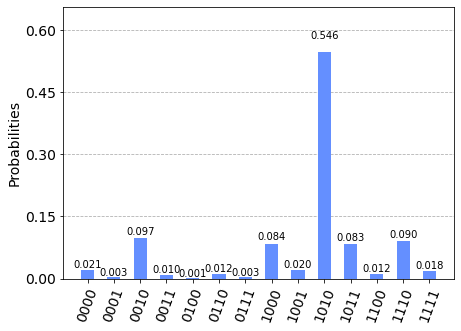

In [6]:
# OUTDATED CODE
# SEE CELL BELOW FOR BATCH JOB

from qiskit.tools.monitor import *
def run_job(qc):
    # runs test on all inputs
    # run cicuits in one batch
    #job_manager = IBMQJobManager()
    #job_set = job_manager.run([qc_0, qc_1], backend=provider.get_backend('ibmq_qasm_simulator'), name='msrincom_test')
    #job_monitor(job_set)
    #job_set.error_message()
    job = execute(qc, backend=provider.get_backend('ibmq_qasm_simulator'), shots=1000)
    job_monitor(job)
    return job
qc_0 = bb84_states() + measure_circuit(0)
job = run_job(qc_0)
job.result().get_counts(qc_0)
plot_histogram(job.result().get_counts(qc_0))


In [7]:
from qiskit.tools.monitor import *
def run_jobs(qc):
    # run cicuits in one batch
    job_manager = IBMQJobManager()
    job_set = job_manager.run(qc, backend=provider.get_backend('ibmq_qasm_simulator'), name='msrincom_test')
    job_set.error_messages()
    return job_set
qc_0 = bb84_states() + measure_circuit(0)
qc_1 = bb84_states() + measure_circuit(1)
managed_job = run_jobs([qc_0,qc_1])


In [8]:
result_0 = managed_job.job(0)[0].result()
result_1 = managed_job.job(1)[0].result()
#managed_job.job(0)[0].error_message()
result_0.get_counts(qc_0)

{'0101': 2,
 '0111': 2,
 '1100': 18,
 '0100': 4,
 '1001': 9,
 '1010': 554,
 '0001': 1,
 '1111': 22,
 '1110': 94,
 '0010': 89,
 '0000': 16,
 '1011': 90,
 '0110': 21,
 '0011': 13,
 '1101': 4,
 '1000': 85}

Job Status: job has successfully run


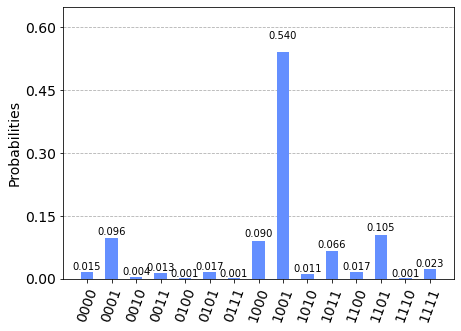

In [9]:
qc_1 = bb84_states() + measure_circuit(1)
job2 = run_job(qc_1)
job2.result().get_counts(qc_1)
plot_histogram(job2.result().get_counts(qc_1))

In [10]:
counts = job2.result().get_counts(qc_1)
print(counts)

# 2x4 matrix for probabilities
# row for x
# column for y
bins = (2,4)
bins = np.zeros(bins)

# iterate over dictionary
for state in counts:
    for i in range(0,4):
        r = int(state[i])
        c = 3 - i
        bins[r,c] += counts[state]
print(bins)
# convert bins to probibilities
probs = bins / 1000.0
print(probs)

{'0101': 17, '0111': 1, '0000': 15, '1100': 17, '1011': 66, '0100': 1, '1001': 540, '1010': 11, '0001': 96, '1111': 23, '0011': 13, '1110': 1, '1101': 105, '0010': 4, '1000': 90}
[[139. 881. 835. 147.]
 [861. 119. 165. 853.]]
[[0.139 0.881 0.835 0.147]
 [0.861 0.119 0.165 0.853]]


In [11]:
from qiskit.quantum_info import Statevector

In [12]:
qc = bb84_states()
state = Statevector.from_instruction(qc)
print(state)
real_state = [0,0,0.5+0.j,0,0,0,0.5,0,0,0,-0.5,0,0,0,-0.5,0]
print(state.data)
print(state.data == real_state)
print(state.data[2])
error = abs(state.data-real_state)
epsilon = 1.0E-4
any(x>epsilon for x in error)

Statevector([ 0. +0.j,  0. +0.j,  0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j,
              0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j, -0.5+0.j,  0. +0.j,
              0. +0.j,  0. +0.j, -0.5+0.j,  0. +0.j],
            dims=(2, 2, 2, 2))
[ 0. +0.j  0. +0.j  0.5+0.j  0. +0.j  0. +0.j  0. +0.j  0.5+0.j  0. +0.j
  0. +0.j  0. +0.j -0.5+0.j  0. +0.j  0. +0.j  0. +0.j -0.5+0.j  0. +0.j]
[ True  True False  True  True  True False  True  True  True False  True
  True  True False  True]
(0.4999999999999999+0j)


False

# Communicator Testing

In [13]:
communicator = quantum_communicator.LocalCommunicator([provider.get_backend('ibmq_qasm_simulator')])
print(communicator)
pre_operations = bb84_states()
post_operations = (QuantumCircuit(4),measure_circuit(0))
display(post_operations[1].draw())
size = max(post_operations[0].num_qubits,post_operations[1].num_qubits)
print(size)
counts = communicator.run_and_transmit("nothing","nothing",pre_operations,post_operations,1000)
plot_histogram(counts)

AttributeError: module 'device_independent_test.quantum_communicator' has no attribute 'LocalCommunicator'

In [ ]:
communicator = quantum_communicator.LocalCommunicator([provider.get_backend('ibmq_qasm_simulator')])
pre_operations = [bb84_states(),bb84_states()]
post_operations = [[QuantumCircuit(4),QuantumCircuit(4)],[measure_circuit(0),QuantumCircuit(4)]]
counts = communicator.batch_run_and_transmit("","",pre_operations,post_operations,1000)
print(counts)

In [ ]:
test = [[1,2,3],[4,5,6],[7,8,9]]
print(test)
print(test[0][2])
print(test[1][0])

In [ ]:
communicator = quantum_communicator.LocalCommunicator([provider.get_backend('ibmq_qasm_simulator')])
pre_operations = [bb84_states(),QuantumCircuit(4),bb84_states()]
#post_operations = [[QuantumCircuit(4),QuantumCircuit(4),QuantumCircuit(4)],[measure_circuit(0),QuantumCircuit(4),measure_circuit(1)]]
post_operations = [[QuantumCircuit(4),measure_circuit(0)],[QuantumCircuit(4),QuantumCircuit(4)],[QuantumCircuit(4),QuantumCircuit(4)]]
count0 = communicator.run_and_transmit("","",pre_operations[0],post_operations[0],1000)
#count1 = communicator.run_and_transmit("","",pre_operations[0],[post_operations[0][0],post_operations[1][0]],1000)
#count2 = communicator.run_and_transmit("","",pre_operations[0],[post_operations[0][0],post_operations[1][0]],1000)
count1 = communicator.run_and_transmit("","",pre_operations[1],post_operations[1],1000)
count2 = communicator.run_and_transmit("","",pre_operations[2],post_operations[2],1000)
print(count2)
#print(count1)
#print(count2)

In [ ]:
print(count0)

In [ ]:
circuits = [bb84_states()+measure_circuit(0),bb84_states()+measure_circuit(1),bb84_states()]
job_manager = IBMQJobManager()
job_set = execute(circuits,backend=provider.get_backend('ibmq_qasm_simulator'),shots=1000)

# retrieve and return counts
counts = []
for i in range (0,len(circuits)):
    if job_set.result().data(circuits[i]) == {}:
        counts.append({"NO_MEASURMENT":0})
    else:
        counts.append(job_set.result().get_counts(circuits[i]))
    
print(counts)

In [ ]:
result_1 = job_set.job(1)[0].result()
counts = result_2.get_counts(circuits[1])

In [ ]:
results = job_set.results()
print(results)

In [ ]:
counts = results.data(QuantumCircuit(2))
print(counts)

In [ ]:
# Build a thousand circuits.
from qiskit.circuit.random import random_circuit
circs = []
for _ in range(10):
    circs.append(random_circuit(n_qubits=5, depth=4))

# Use Job Manager to break the circuits into multiple jobs.
job_manager = IBMQJobManager()
job_set_foo = job_manager.run(circs, backend=provider.get_backend('ibmq_qasm_simulator') , name='foo')

In [ ]:
testresults = job_set_foo.results()
test5 = testresults.get_counts(5)